# SOEN471-PROJECT - Suicide and Depression Sentiment Analysis - Team 13

# Team Members:
- Mohammad Ali Zahir - 40077619
- Samantha Guillemette - 26609198
- Marita Brichan - 40138194	
- Souvik Polol Alam	- 40044092	

## Librairies

### Run next cell to install all the required libraries

In [72]:
# !pip install dask-ml
# !pip install seaborn
# !pip install neattext
# !pip install tqdm
# !pip install nltk
# !pip install scikit-learn
# !pip install tabulate 

### Librairies Used

In [73]:
import dask.dataframe as dd
import dask.array as da
import dask_ml.preprocessing as dmp
import dask_ml.model_selection as dms
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import neattext.functions as nfx
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate

## Load Data

In [74]:
dask = dd.read_csv("./data/Suicide_Detection.csv")
dask = dask.drop('Unnamed: 0', axis = 1)

dask.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Previewing Data

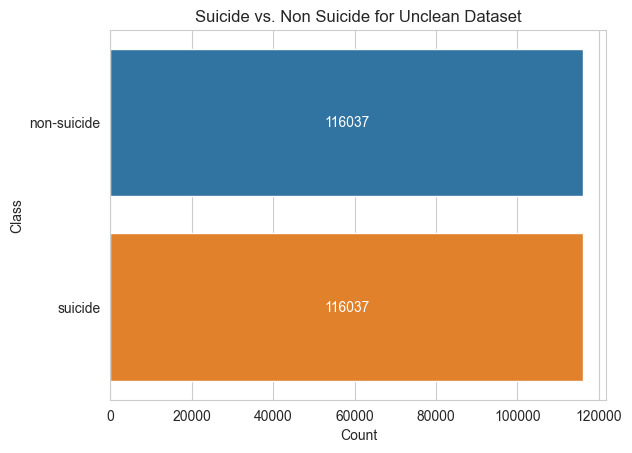

In [75]:
class_counts = dask['class'].value_counts().compute()

# Create a bar plot of the value counts using Seaborn
ax = sns.barplot(x=class_counts.values, y=class_counts.index)

for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2,
            str(class_counts.values[i]), fontsize=10, color='white', ha='center', va='center')


# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide for Unclean Dataset')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()

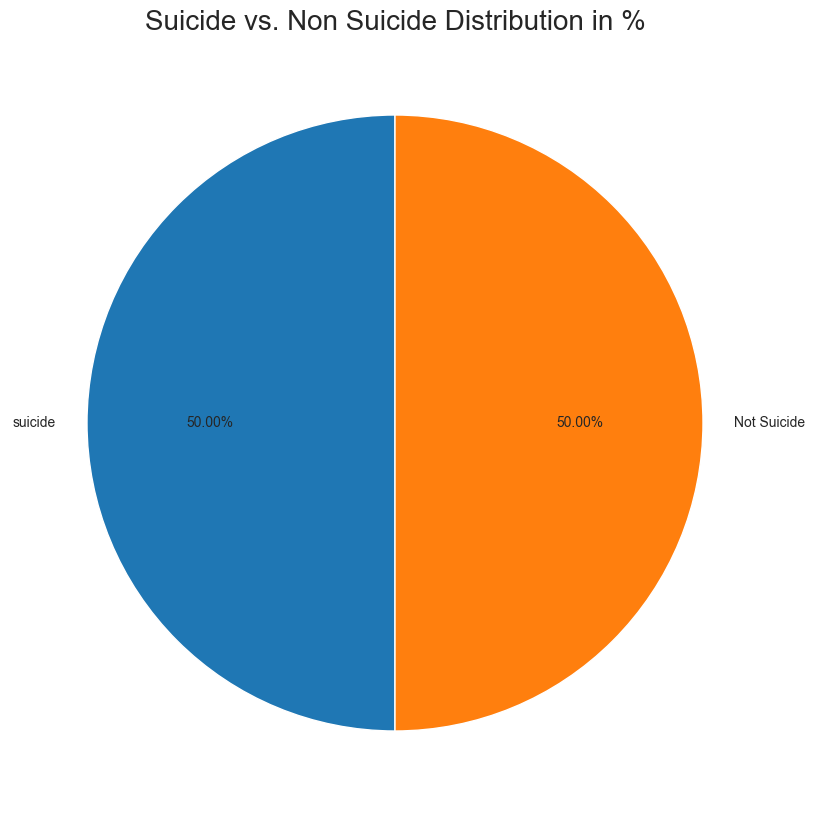

In [76]:
plt.figure(figsize=(10,10))
plt.pie(class_counts.values, startangle=90, autopct='%0.2f%%', labels=['suicide','Not Suicide'])
plt.title('Suicide vs. Non Suicide Distribution in %',fontdict={'size':20})
plt.show()

# Preprocessing Data

In [101]:
# Create a function which preprocess the text by using the nltk, neattext and WordNetLemmatizer and the tqdm librairies
def preprocess_text(text):
    processed_text=[]
    lemmatizer = WordNetLemmatizer()
    for sequence in tqdm(text):
        sequence=sequence.lower()
        sequence=nfx.remove_special_characters(sequence)
        sequence=nfx.remove_stopwords(sequence)
        sequence = nfx.remove_emojis(sequence)
        words = nltk.word_tokenize(sequence)
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        sequence = ' '.join(lemmatized_words)
        processed_text.append(sequence)
    return processed_text


## Splitting Training and Test Data

In [102]:
train_data,test_data=dms.train_test_split(dask,test_size=0.2,random_state=10, shuffle=True)

#### Visualize Split Data

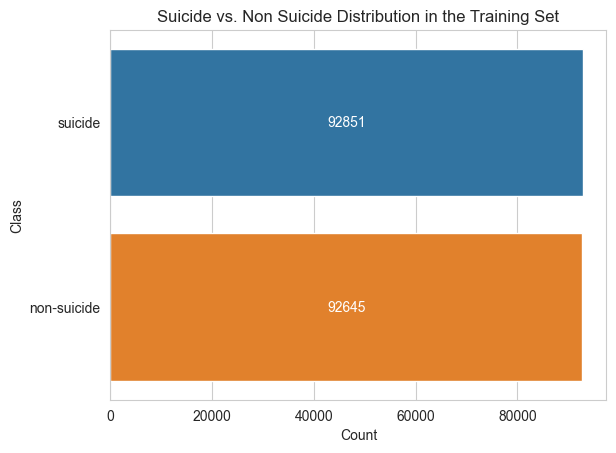

In [93]:
train_counts = train_data['class'].value_counts().compute()

ax = sns.barplot(x=train_counts.values, y=train_counts.index)

# Add the count value inside each bar
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2,
            str(train_counts.values[i]), fontsize=10, color='white', ha='center', va='center')

# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide Distribution in the Training Set')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()

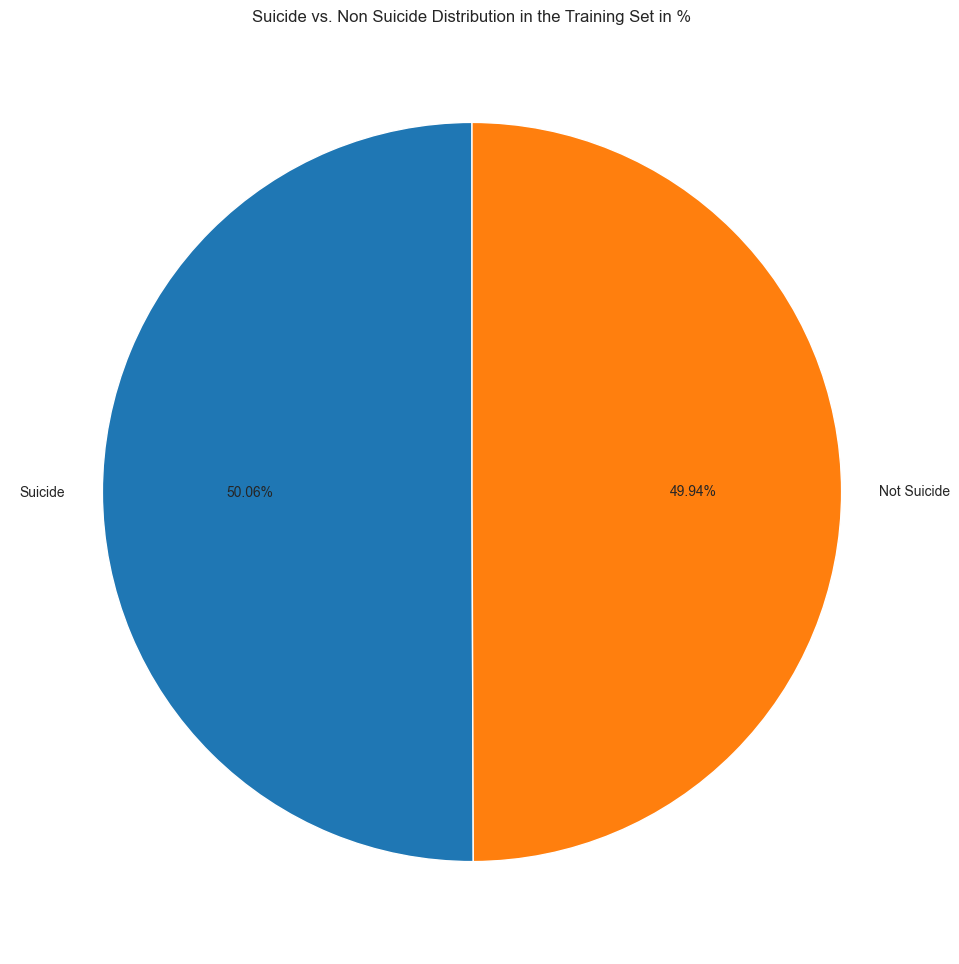

In [95]:
plt.figure(figsize=(12,12))
plt.pie(train_counts.values, startangle=90, autopct='%0.2f%%', labels=['Suicide','Not Suicide'])
plt.title('Suicide vs. Non Suicide Distribution in the Training Set in %')
plt.show()

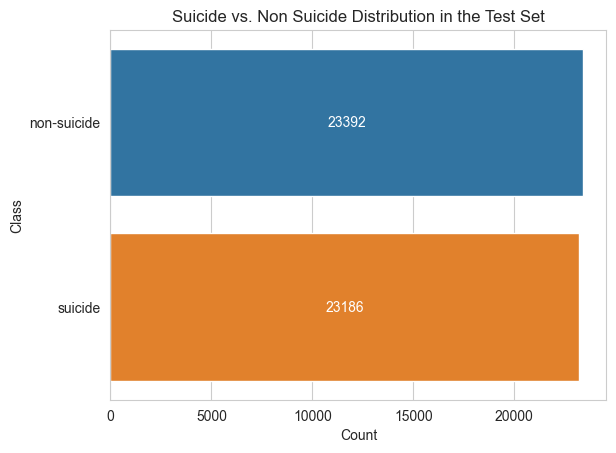

In [96]:
test_counts = test_data['class'].value_counts().compute()

ax = sns.barplot(x=test_counts.values, y=test_counts.index)

# Add the count value inside each bar
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2,
            str(test_counts.values[i]), fontsize=10, color='white', ha='center', va='center')

# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide Distribution in the Test Set')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()

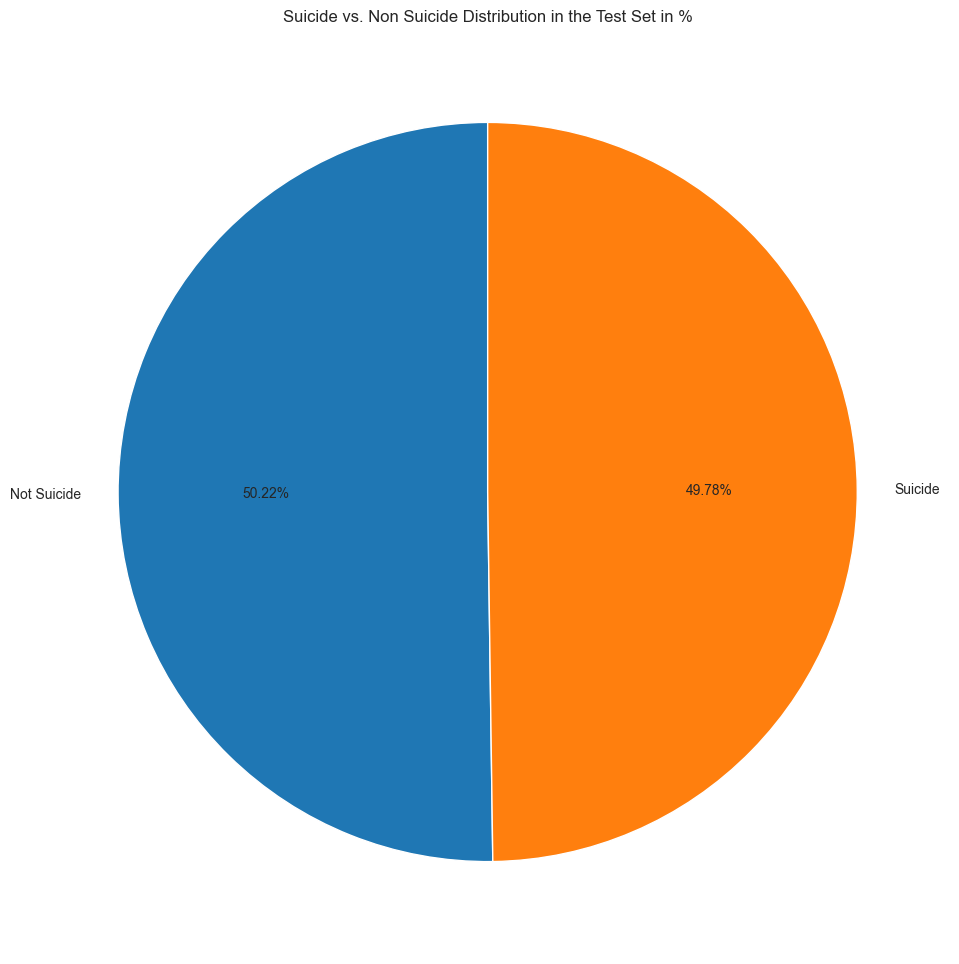

In [89]:
plt.figure(figsize=(12,12))
plt.pie(test_counts.values, startangle=90, autopct='%0.2f%%', labels=['Not Suicide','Suicide'])
plt.title('Suicide vs. Non Suicide Distribution in the Test Set in %')
plt.show()

### Preprocessing Split Data

In [103]:
cleaned_train_text=preprocess_text(train_data.text.compute())
cleaned_test_text=preprocess_text(test_data.text.compute())

100%|██████████| 46578/46578 [00:23<00:00, 1964.69it/s]


### Visualize Cleaned Split Data

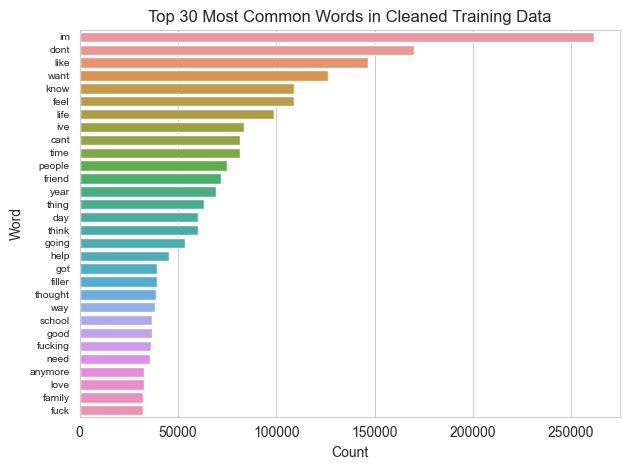

In [105]:
# Join all cleaned texts into one long string
all_train_text = ' '.join(cleaned_train_text)

# Tokenize the text using NLTK
words = nltk.tokenize.word_tokenize(all_train_text)

# Lemmatize the words using NLTK's WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
words = [lemmatizer.lemmatize(word) for word in words]

# Compute the frequency of each word using NLTK's FreqDist function
word_freq = nltk.FreqDist(words)

# Extract the 50 most common words
top_words = word_freq.most_common(30)

# Create a bar plot of the top 50 words using Seaborn
sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words])
plt.title('Top 30 Most Common Words in Cleaned Training Data')
plt.xlabel('Count')
plt.ylabel('Word')
plt.yticks(fontsize=7.5)
plt.gca().tick_params(axis='y', which='major', labelsize=7.5)
plt.tight_layout()
plt.show()







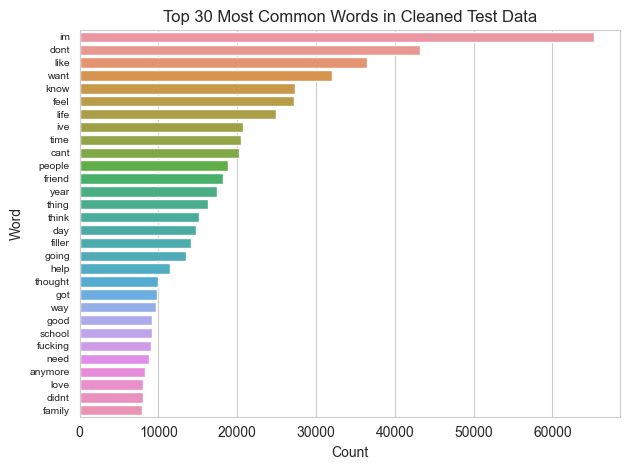

In [106]:
# Join all cleaned texts into one long string
all_test_text = ' '.join(cleaned_test_text)

# Tokenize the text using NLTK
words = nltk.tokenize.word_tokenize(all_test_text)

# Lemmatize the words using NLTK's WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
words = [lemmatizer.lemmatize(word) for word in words]

# Compute the frequency of each word using NLTK's FreqDist function
word_freq = nltk.FreqDist(words)

# Extract the 50 most common words
top_words = word_freq.most_common(30)

# Create a bar plot of the top 50 words using Seaborn
sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words])
plt.title('Top 30 Most Common Words in Cleaned Test Data')
plt.xlabel('Count')
plt.ylabel('Word')
plt.yticks(fontsize=7.5)
plt.gca().tick_params(axis='y', which='major', labelsize=7.5)
plt.tight_layout()
plt.show()



## Vectorize Data

In [107]:

# Create a TF-IDF vectorizer object
vectorizer = TfidfVectorizer()

# Vectorize the cleaned training and test data
X_train = vectorizer.fit_transform(cleaned_train_text)
X_test = vectorizer.transform(cleaned_test_text)

# Get the target values for the training and test data
y_train = train_data['class'].compute().values
y_test = test_data['class'].compute().values



## Applying Models

### Multinomial Naive Bayes Model Training and Prediction

In [113]:
# Train a Multinomial Naive Bayes classifier on the transformed data
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_nb = clf.predict(X_test)

### Random Forest Model Training and Prediction

In [108]:
# Create a Random Forest Classifier object
clf_rf = RandomForestClassifier(n_estimators=10, random_state=10)

# Fit the classifier on the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = clf_rf.predict(X_test)



## Evaluate Models

### Multinomial Naive Bayes Model Evaluation

In [114]:
# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_nb)

print("Accuracy:", accuracy)



Accuracy: 0.8719137790373137


In [115]:
# Print the classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

 non-suicide       0.98      0.76      0.86     23392
     suicide       0.80      0.98      0.88     23186

    accuracy                           0.87     46578
   macro avg       0.89      0.87      0.87     46578
weighted avg       0.89      0.87      0.87     46578



### Random Forest Model Evaluation

In [ ]:
# # Print the classification report
rfc_class_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(rfc_class_report).transpose()

# Format the values as percentages
df.loc[:, 'precision':'f1-score'] = df.loc[:, 'precision':'f1-score'].applymap(lambda x: f'{x:.2%}')

# Print the dataframe
report_table = tabulate(df.drop('accuracy'), headers='keys',tablefmt="grid",
            stralign="right", numalign="right")
print(f"The Classification report for the Random Forest Model\n {report_table}")

# Print the accuracy score separately
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy Score of the Random Forest Model: {accuracy:.2%}")


In [ ]:
# Get the unique labels in the data
labels = np.unique(y_test)


# Extract the precision, recall, and f1-score values for each class
precision = [rfc_class_report[label]['precision'] for label in labels]
recall = [rfc_class_report[label]['recall'] for label in labels]
f1_score = [rfc_class_report[label]['f1-score'] for label in labels]

# Convert the values to percentages
precision_pct = [p * 100 for p in precision]
recall_pct = [r * 100 for r in recall]
f1_score_pct = [f * 100 for f in f1_score]

# Create a bar plot for each metric
x_pos = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(18,18))
ax.bar(x_pos - width, precision_pct, width, label='Precision')
ax.bar(x_pos, recall_pct, width, label='Recall')
ax.bar(x_pos + width, f1_score_pct, width, label='F1-Score')

# Set the axis labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Value (%)')
ax.set_title('Classification Report Metrics for the Random Forest Model')

# Set the tick labels and legend
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()

# Add the percentage values as text above each bar
for i in range(len(labels)):
    ax.text(x_pos[i] - width, precision_pct[i] + 1, f'{precision_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i], recall_pct[i] + 1, f'{recall_pct[i]:.1f}%', ha='center')
    ax.text(x_pos[i] + width, f1_score_pct[i] + 1, f'{f1_score_pct[i]:.1f}%', ha='center')

# Show the plot
plt.show()

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Create the heatmap using seaborn
plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set the axis labels
plt.title('Confusion Matrix for the Random Forest Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()